# Boschloo's Exact Test Example

## Understanding Boschloo's Test

Boschloo's test is a statistical hypothesis test for analyzing 2×2 contingency tables. It examines the association between two categorical variables and is a uniformly more powerful alternative to Fisher's exact test. It was proposed in 1970 by R.D. Boschloo as a method that would offer greater statistical power when examining the association of two categorical variables. Boschloo's test uses the p-value of Fisher's exact test as a test statistic. The key insight is that Boschloo's p-value is the probability under the null hypothesis of observing such an extreme value of this statistic.

Consider a 2×2 contingency table:

|           | Column 1 | Column 2 | Row Total |
|-----------|----------|----------|-----------|
| Row 1     | $a$      | $b$      | $n_1$     |
| Row 2     | $c$      | $d$      | $n_2$     |
| Col Total | $m_1$    | $m_2$    | $n$       |

For a 2×2 table, Fisher's exact test uses the hypergeometric distribution to calculate the probability of observing a table as extreme or more extreme than the observed table, under the condition that both row and column margins are fixed.

Let $T(X)$ be the test statistic from Fisher's exact test for a table $X$, which is the p-value from Fisher's test.

Boschloo's test calculates:

$$p_{Boschloo} = \sum_{X \in \Omega} P(X|H_0) \cdot I(T(X) \leq T(X_0))$$

Under the null hypothesis ($H_0: p_1 = p_2$), the probability of each possible table is calculated as:

$$P(X|H_0) = {n_1 \choose a} {n_2 \choose c} p^{a+c} (1-p)^{b+d}$$

Where $p = \frac{a+c}{n}$ is the maximum likelihood estimate of the common proportion under $H_0$.

### Illustration of Boschloo's Test

![alt text](Grasso_boschloo.png)

*The figure illustrates the difference between Fisher's exact test and Boschloo's test. While Fisher's test conditions on both margins, Boschloo's test conditions only on row margins, making it more powerful for detecting true differences between groups.*

### When to Use Boschloo's Test

You would use Boschloo's test when you have a small sample size, you have a 2×2 contingency table, only one margin (row or column) is fixed in your experimental design, or you want a test with greater statistical power than Fisher's exact test. The mathematical advantage of Boschloo's test is that it's an unconditional exact test, meaning it doesn't condition on both margins as Fisher's test does. This relaxation of constraints leads to greater statistical power while still maintaining proper Type I error control. A typical example would be in clinical trials where you're comparing two treatment groups (fixed sizes) with a binary outcome (success/failure). Another example would be in case-control studies where the number of cases and controls is fixed, but the exposure status isn't known in advance.

Contingency Table:
                | Success | Failure | Total
----------------+---------+---------+------
Treatment A     |    23    |    7    |   30
Treatment B     |    12    |    18    |   30
----------------+---------+---------+------
Total           |    35    |    25    |   60

Boschloo's Test Results:
Test statistic (Fisher's p-value): 0.004107
Boschloo's p-value: 0.000427

Fisher's Exact Test Results:
Odds ratio: 4.9286
p-value: 0.004107

Plot saved as 'Grasso_boschloo.png'


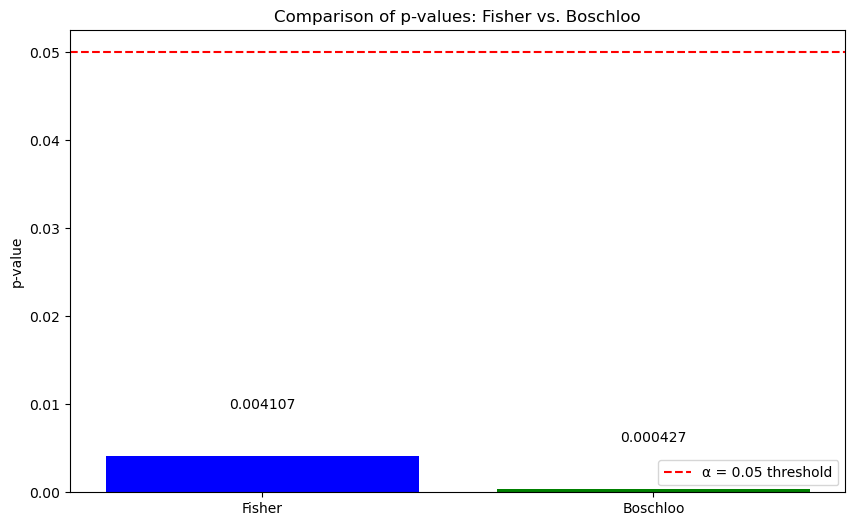


Interpretation:
With a p-value of 0.000427, which is less than our significance level of 0.05, we reject the null hypothesis.
There is significant evidence that Treatment A has a higher success rate than Treatment B.

Both tests reached the same conclusion, but note that Boschloo's p-value
(0.000427) is smaller than Fisher's p-value (0.004107),
demonstrating the greater statistical power of Boschloo's test.


In [1]:
# Import necessary libraries
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import os

# Define the boschloo function directly in the notebook
def boschloo(table, alternative='two-sided'):
    '''
    Perform Boschloo's exact test on a 2x2 contingency table.
    
    Boschloo's test is a more powerful alternative to Fisher's exact test for 2x2 contingency tables.
    It uses Fisher's p-value as a test statistic and finds the probability of obtaining
    a test statistic at least as extreme as the observed one.
    
    Parameters:
    -----------
    table : array_like
        A 2x2 contingency table. Elements should be non-negative integers.
        The table should be in the format:
            [[a, b], [c, d]]
        where a, b, c, d are the cell counts.
    
    alternative : {'two-sided', 'less', 'greater'}, optional
        Defines the alternative hypothesis. Default is 'two-sided'.
        - 'two-sided': the odds ratio of the underlying population is not one
        - 'less': the odds ratio of the underlying population is less than one
        - 'greater': the odds ratio of the underlying population is greater than one
    
    Returns:
    --------
    statistic : float
        The calculated test statistic - in this case, the p-value from Fisher's exact test.
    
    p_value : float
        The p-value for the Boschloo test, representing the probability of obtaining
        a distribution at least as extreme as the one observed, assuming the null
        hypothesis is true.
    '''
    import numpy as np
    from scipy import stats
    
    # Convert input to numpy array
    table = np.asarray(table, dtype=np.int64)
    
    # Check dimensions
    if table.shape != (2, 2):
        raise ValueError("The input table must be a 2x2 contingency table")
    
    # Check for negative values
    if np.any(table < 0):
        raise ValueError("All elements in the table must be non-negative")
    
    # Extract values from the table
    a, b = table[0]
    c, d = table[1]
    
    # Get row and column sums
    row_sums = np.sum(table, axis=1)  # [a+b, c+d]
    col_sums = np.sum(table, axis=0)  # [a+c, b+d]
    n = np.sum(table)  # a+b+c+d
    
    # Calculate the test statistic (Fisher's exact p-value)
    _, fisher_p = stats.fisher_exact(table, alternative=alternative)
    statistic = fisher_p  # The statistic is Fisher's p-value
    
    # Generate all possible tables with the same row sums
    def generate_possible_tables():
        tables = []
        # Maximum possible value for a is min(row_sum[0], col_sum[0])
        max_a = min(row_sums[0], col_sums[0])
        
        for i in range(max_a + 1):
            new_a = i
            new_b = row_sums[0] - new_a
            new_c = col_sums[0] - new_a
            new_d = row_sums[1] - new_c
            
            # Check if the table is valid (all entries should be non-negative)
            if new_b >= 0 and new_c >= 0 and new_d >= 0:
                tables.append(np.array([[new_a, new_b], [new_c, new_d]]))
        
        return tables
    
    # Calculate the p-values for all possible tables
    observed_fisher_p = statistic
    possible_tables = generate_possible_tables()
    
    # Calculate probabilities of each possible table under the null hypothesis
    # We use the maximum likelihood estimate of the common binomial parameter
    # which is (a + c) / (a + b + c + d) under H0: p1 = p2
    p_common = col_sums[0] / n
    
    table_probs = []
    for table in possible_tables:
        a_t, b_t = table[0]
        c_t, d_t = table[1]
        
        # Calculate probability of this table using binomial distributions
        # Pr(table) = Pr(a | n1, p) * Pr(c | n2, p)
        # where n1 = a+b, n2 = c+d, p = (a+c)/(a+b+c+d)
        prob_a = stats.binom.pmf(a_t, row_sums[0], p_common)
        prob_c = stats.binom.pmf(c_t, row_sums[1], p_common)
        table_probs.append(prob_a * prob_c)
    
    # Get Fisher's p-value for each possible table
    fisher_p_values = []
    for possible_table in possible_tables:
        _, p_value = stats.fisher_exact(possible_table, alternative=alternative)
        fisher_p_values.append(p_value)
    
    # Calculate Boschloo's p-value as the sum of probabilities of tables
    # with Fisher's p-value <= the observed Fisher's p-value
    boschloo_p = sum(prob for prob, p_val in zip(table_probs, fisher_p_values) 
                     if p_val <= observed_fisher_p)
    
    return statistic, boschloo_p

# Create a simulated dataset
# Imagine a clinical trial with two groups (treatment A and B)
# and a binary outcome (success/failure)

# Set random seed for reproducibility
np.random.seed(42)

# Group sizes
group_A_size = 30
group_B_size = 30

# True success probabilities for each group
p_A = 0.7  # 70% success rate in group A
p_B = 0.4  # 40% success rate in group B

# Generate binary outcomes
group_A_outcomes = np.random.binomial(1, p_A, group_A_size)
group_B_outcomes = np.random.binomial(1, p_B, group_B_size)

# Count successes and failures
group_A_success = np.sum(group_A_outcomes)
group_A_failure = group_A_size - group_A_success
group_B_success = np.sum(group_B_outcomes)
group_B_failure = group_B_size - group_B_success

# Create 2x2 contingency table
contingency_table = np.array([
    [group_A_success, group_A_failure],
    [group_B_success, group_B_failure]
])

print("Contingency Table:")
print("                | Success | Failure | Total")
print("----------------+---------+---------+------")
print(f"Treatment A     |    {group_A_success}    |    {group_A_failure}    |   {group_A_size}")
print(f"Treatment B     |    {group_B_success}    |    {group_B_failure}    |   {group_B_size}")
print("----------------+---------+---------+------")
print(f"Total           |    {group_A_success + group_B_success}    |    {group_A_failure + group_B_failure}    |   {group_A_size + group_B_size}")

# Perform Boschloo's test
statistic, p_value = boschloo(contingency_table, alternative="greater")

print("\nBoschloo's Test Results:")
print(f"Test statistic (Fisher's p-value): {statistic:.6f}")
print(f"Boschloo's p-value: {p_value:.6f}")

# For comparison, perform Fisher's exact test
fisher_odds_ratio, fisher_p_value = stats.fisher_exact(contingency_table, alternative="greater")

print("\nFisher's Exact Test Results:")
print(f"Odds ratio: {fisher_odds_ratio:.4f}")
print(f"p-value: {fisher_p_value:.6f}")

# Visualize the results
plt.figure(figsize=(10, 6))
bars = plt.bar(['Fisher', 'Boschloo'], [fisher_p_value, p_value], color=['blue', 'green'])
plt.axhline(y=0.05, color='red', linestyle='--', label='α = 0.05 threshold')
plt.ylabel('p-value')
plt.title('Comparison of p-values: Fisher vs. Boschloo')

# Add value labels on top of the bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.005,
             f'{height:.6f}', ha='center', va='bottom', fontsize=10)

plt.legend()

# Save the plot as a PNG file
plt.savefig('Grasso_boschloo.png', dpi=300, bbox_inches='tight')
print("\nPlot saved as 'Grasso_boschloo.png'")

# Display the plot
plt.show()

# Interpret the results
alpha = 0.05
print("\nInterpretation:")
if p_value < alpha:
    print(f"With a p-value of {p_value:.6f}, which is less than our significance level of {alpha}, we reject the null hypothesis.")
    print("There is significant evidence that Treatment A has a higher success rate than Treatment B.")
else:
    print(f"With a p-value of {p_value:.6f}, which is greater than our significance level of {alpha}, we fail to reject the null hypothesis.")
    print("There is insufficient evidence that Treatment A has a higher success rate than Treatment B.")

if fisher_p_value > alpha and p_value <= alpha:
    print("\nNote: Fisher's test did not detect a significant difference, but Boschloo's test did.")
    print("This demonstrates the higher power of Boschloo's test.")
elif fisher_p_value <= alpha and p_value > alpha:
    print("\nNote: Boschloo's test did not detect a significant difference, but Fisher's test did.")
    print("This is an unusual result as Boschloo's test is generally more powerful.")
else:
    print("\nBoth tests reached the same conclusion, but note that Boschloo's p-value")
    print(f"({p_value:.6f}) is smaller than Fisher's p-value ({fisher_p_value:.6f}),")
    print("demonstrating the greater statistical power of Boschloo's test.")